# Tutorial 2: Membrane Protein
Date: 5 Jun 2025

Reference: https://tutorials.gromacs.org/membrane-protein.html

# 1. Download files
maltoporin channel, a trimeric protein located at the outer membrane of Gram-negative bacteria, facilitates the translocation of the polysaccharide maltodextrin. The 3D structure (PDB code 1MAL) is downloaded from the [RCSB website](https://www.rcsb.org/structure/1MAL).

In [4]:
import nglview as ng
file_path = "input/1mal.pdb"
show = ng.show_structure_file(file_path)
show

NGLWidget()

# 2. Build protein-membrane system
[CHARMM-GUI Input Generator](https://www.charmm-gui.org/) is a web-based tool to generate GROMACS inputs from protein-membrane system. Tutorial is accessed from [here](https://zenodo.org/records/10794193).

1. In Bilayer Builder, upload PDB file
2. Select proteins and specify initial and final residues (Select all) 
3. Specify system pH, perform terminal group patching, establish disulfide bond, and introduce phosphorylation to the residue (Default setting)
4. Orient the protein (Use PDB orientation)
5. Define shape and size of the system and select lipid type
6. Select ion type
7. Select force field
8. Generate output

We will then copy the topology, parameter, structure and customised mdp files provided in the tutorial to the `run` directory.

In [6]:
!ls input/charmm-gui-1MAL/gromacs

index.ndx                 step6.0_minimization.mdp  step6.5_equilibration.mdp
README                    step6.1_equilibration.mdp step6.6_equilibration.mdp
step5_input.gro           step6.2_equilibration.mdp step7_production.mdp
step5_input.pdb           step6.3_equilibration.mdp topol.top
step5_input.psf           step6.4_equilibration.mdp toppar


In [17]:
!mkdir run
!cd run
!pwd
# Copy topology, parameter, and structure files to run folder
!cp    input/charmm-gui-1MAL/gromacs/step5_input.gro          run
!cp    input/charmm-gui-1MAL/gromacs/step5_input.pdb          run
!cp    input/charmm-gui-1MAL/gromacs/topol.top                run
!cp    input/charmm-gui-1MAL/gromacs/index.ndx                run
!cp -r input/charmm-gui-1MAL/gromacs/toppar                   run
# Updated mdp files
!cp    input/mdp/*                                            run

mkdir: run: File exists
/Users/heiley/Downloads/gromacs-tutorial/tutorial-2


In [30]:
!ls run

index.ndx                           step6.4_equilibration_NPT_step2.mdp
step5_input.gro                     step6.5_equilibration_NPT_step3.mdp
step5_input.pdb                     step6.6_equilibration_NPT_step4.mdp
step6.0_minimization.mdp            step7_production_revised.mdp
step6.1_equilibration_NVT_step1.mdp topol.top
step6.2_equilibration_NVT_step2.mdp toppar
step6.3_equilibration_NPT_step1.mdp


# 3. Understanding a mdp file
Here we will use the mdp file for minimisation as a reference. 

Position restraints
- integrator=steep: For energy minimisation
- nsteps: Maximum number of steps to integrate
- emtol: Minimization is converged when the maximum force is smaller than this value
- emstep: Initial step-size

Neighbour searching
- cutoff-scheme=Verlet: Cut-off schemes mean interactions are only computed up to a fixed distance and buffer (skin). 
- nstlist: Steps before updating
- rlist: Cut-off distance without dynamics, Verlet buffer is used when there is dynamics

vdW
- vdWtype=Cut-off: Cut-off calculation for van der Waals force 
- vdW-modifier=Force-switch: Smoothly switch the vdW to zero from `rvdw_switch` to `rvdw`
- rvdw_switch: Switch the LJ potential
- rvdw: Cut-off distance for LJ potential

Electrostatics
- coulombtype=pme: Fast smooth Particle-Mesh Ewald (SPME) electrostatics
- rcoulomb: Cut-off distance for coulomb force

Bonds
- constraints=h-bonds: Convert bonds with H-atoms to constraints
- constraint_algorithm=LINCS: LINCS is an algorithm that resets bonds to their correct lengths after an unconstrained update. In the first step, the projections of the new bonds on the old bonds are set to zero. In the second step, a correction is applied for the lengthening of the bonds due to rotation

In [20]:
!cat input/mdp/step6.0_minimization.mdp

;;Preprocessing
title                   = CHARMM steepest descent energy minimization

; Position restraints   
;not applicable                      
;;Run and output control
integrator              = steep       ; A steepest descent algorithm for energy minimization
nsteps                  = 50000       ; Maximum number of steps to integrate or minimize
emtol                   = 1000.0      ; Tolerance [kJ mol-1 nm-1]
emstep                  = 0.01 

;;Neighbour searching
cutoff-scheme           = Verlet      ; Generate a pair list with buffering 
nstlist                 = 10          ; Frequency to update the neighbour list [steps]
rlist                   = 1.2


;;VdW
vdwtype                 = Cut-off
vdw-modifier            = Force-switch 
rvdw_switch             = 1.0         ; Where to start switching the LJ potential [nm]
rvdw                    = 1.2         ; Distance for the LJ or Buckingham cut-off [nm]

;;Electrostatics
coulombtype             = pme         ; Fast smooth Pa

# 4. Energy minimisation
As always, we first use `grompp` generate the binary file (.tpr) that combines topology (.top), simulation parameters (.mdp) and structure (.gro).

**Specifications**
- f: MD parameter input (.mdp)
- c: Structure configuration input (.gro)
- r: Structure restraint input (.gro)
- p: Process topology (.top)
- o: Binary file output (.tpr)

**Output**
- minimisation.tpr: Atomic-level input (generated from grompp) 

In [35]:
## Step 1: Generate binary file 
%cd run
!gmx grompp -f step6.0_minimization.mdp -c step5_input.gro -r step5_input.gro -p topol.top -o minimisation.tpr

[Errno 2] No such file or directory: 'run'
/Users/heiley/Downloads/gromacs-tutorial/tutorial-2/run
                 :-) GROMACS - gmx grompp, 2025.1-Homebrew (-:

Executable:   /opt/homebrew/bin/../Cellar/gromacs/2025.1/bin/gmx
Data prefix:  /opt/homebrew/bin/../Cellar/gromacs/2025.1
Working dir:  /Users/heiley/Downloads/gromacs-tutorial/tutorial-2/run
Command line:
  gmx grompp -f step6.0_minimization.mdp -c step5_input.gro -r step5_input.gro -p topol.top -o minimisation.tpr

Ignoring obsolete mdp entry 'title'
Setting the LD random seed to -896008565

Generated 1755 of the 1770 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 996 of the 1770 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'PROA'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'PROB'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'PROC'

turning H bonds into constraints...

Excluding 3 bonded

In [96]:
!find . -name "minimisation.tpr"

./minimisation.tpr


Then, to run the energy minimisation, use `mdrun`.

**Specifications**
- v: Verbal
- deffnm: Define file name

**Output**
- minimisation.log: Text log file
- minimisation.edr: Binary energy file
- minimisation.trr: Binary fill-precision trajectory
- minimisation.gro: Energy-minimised structure
- minimisation.tpr: Atomic-level input (generated previously)

**Checking**
- Potential energy is negative
- Maximum force is smaller than the tolerance defined in .mdp (1000 kJ/(mol nm)). If not, the system may not be stable enough, and more time is required
- Energy converges, data from `energy`

In [98]:
!gmx mdrun -deffnm minimisation

                  :-) GROMACS - gmx mdrun, 2025.1-Homebrew (-:

Executable:   /opt/homebrew/bin/../Cellar/gromacs/2025.1/bin/gmx
Data prefix:  /opt/homebrew/bin/../Cellar/gromacs/2025.1
Working dir:  /Users/heiley/Downloads/gromacs-tutorial/tutorial-2/run
Command line:
  gmx mdrun -deffnm minimisation

Reading file minimisation.tpr, VERSION 2025.1-Homebrew (single precision)
Using 1 MPI thread
Using 8 OpenMP threads 


Steepest Descents:
   Tolerance (Fmax)   =  1.00000e+03
   Number of steps    =        50000

Step 11, time 0.011 (ps)  LINCS WARNING
relative constraint deviation after LINCS:
rms 0.000087, max 0.011374 (between atoms 45911 and 45913)
bonds that rotated more than 30 degrees:
 atom 1 atom 2  angle  previous, current, constraint length
  45905  45906   34.0    0.1122   0.1122      0.1111
  45905  45907   33.3    0.1112   0.1111      0.1111
  45911  45912   30.8    0.1112   0.1107      0.1111

Step 12, time 0.012 (ps)  LINCS WARNING
relative constraint deviation after LINC

In [100]:
# Check whether all files are generated
!find . -name "minimisation*"

./minimisation.tpr
./minimisation.gro
./minimisation.log
./minimisation.edr
./minimisation.trr


In [103]:
# Check whether requirements are satisfied 
!tail -19 minimisation.log

           Bond            U-B    Proper Dih.  Improper Dih.      CMAP Dih.
    6.51483e+03    3.99347e+04    1.09390e+05    8.82424e+02   -4.51542e+03
          LJ-14     Coulomb-14        LJ (SR)   Coulomb (SR)   Coul. recip.
    2.18926e+04    1.27175e+05    8.29306e+04   -1.96607e+06    1.79287e+04
      Potential Pressure (bar)   Constr. rmsd
   -1.56394e+06   -2.61203e+03    2.89703e-06


Steepest Descents converged to Fmax < 1000 in 2823 steps
Potential Energy  = -1.5639365e+06
Maximum force     =  9.7581628e+02 on atom 38587
Norm of force     =  1.0855692e+01

    D O M A I N   D E C O M P O S I T I O N   S T A T I S T I C S

 av. #atoms communicated per step for force:  2 x 0.0

Finished mdrun on rank 0 Thu Jun  5 16:04:19 2025



In [110]:
# View minimised strucutre
view = ng.show_structure_file(f"minimisation.gro")
## Lipids
view.add_representation("ball+stick",selection="POPC")
## water
view.add_representation("licorice",selection="TIP3P", opacity=0.9)
view.center()
view
#Click and drag to rotate, zoom with your mouse wheel 
#For more information on this viewer have a look at https://github.com/nglviewer/nglview

NGLWidget()

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/var/folders/br/2ygwq5cd58q90bxlwkl2zz580000gn/T/ipykernel_3298/3640011347.py:4: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv('potential.xvg', sep='\s+', header=None, names=['step','energy(kJ Mol-1)'])


                 :-) GROMACS - gmx energy, 2025.1-Homebrew (-:

Executable:   /opt/homebrew/bin/../Cellar/gromacs/2025.1/bin/gmx
Data prefix:  /opt/homebrew/bin/../Cellar/gromacs/2025.1
Working dir:  /Users/heiley/Downloads/gromacs-tutorial/tutorial-2/run
Command line:
  gmx energy -f minimisation.edr -o potential.xvg -xvg none

Opened minimisation.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Potential       12  Pressure      
 13  Constr.-rmsd    14  Vir-XX          15  Vir-XY          16  Vir-XZ        
 17  Vir-YX          18  Vir-YY          19  Vir-YZ   

<Axes: xlabel='step'>

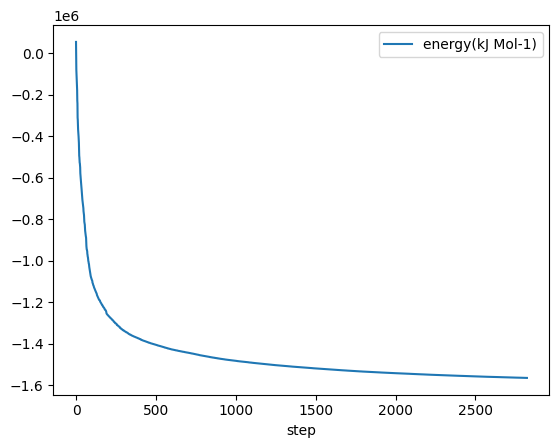

In [114]:
# View convergence of energy
!printf "Potential\n0\n" | gmx energy -f minimisation.edr -o potential.xvg -xvg none
import pandas as pd
df = pd.read_csv('potential.xvg', sep='\s+', header=None, names=['step','energy(kJ Mol-1)'])
df.plot('step')

# 5. Equilibration run - NVT
**Position restraints**
- Avoid drastic rearrangements of critical parts (e.g. to restrain motion in a protein that is subjected to large solvent forces when the solvent is not yet equilibrated)
- Atoms are harmonically restrained to a plane or a line $$V_{pr}(\mathbf{r}_i) = {\frac{1}{2}}k_{pr}|\mathbf{r}_i-\mathbf{R}_i|^2$$$$\begin{split}\begin{array}{rcl}
F_i^x &=& -k_{pr}^x~(x_i - X_i) \\
F_i^y &=& -k_{pr}^y~(y_i - Y_i) \\
F_i^z &=& -k_{pr}^z~(z_i - Z_i)
\end{array}\end{split}$$
- Applied to a special fixed list of atoms, usually generated by `pdb2gmx`
- Critical for membrane proteins, not so much for free proteins
- Other types of restraints: Flat-bottomed position restraints, angle restraints, dihedral restraints, distance restraints, more details can be found [here](https://manual.gromacs.org/documentation/2024.4/reference-manual/functions/restraints.html)

**Molecular dynamics parameters**

- mdp file contains run parameters, generated from the topology file
- define = -DPOSRES:  triggers the inclusion of `posre.itp` into the topology

In [6]:
# restrainst 
!head -4 input/mdp/step6.1_equilibration_NVT_step1.mdp
!head -4 input/mdp/step6.2_equilibration_NVT_step2.mdp
!head -4 input/mdp/step6.3_equilibration_NPT_step1.mdp
!head -4 input/mdp/step6.4_equilibration_NPT_step2.mdp
!head -4 input/mdp/step6.5_equilibration_NPT_step3.mdp
!head -4 input/mdp/step6.6_equilibration_NPT_step4.mdp
!head -4 input/mdp/step7_production_revised.mdp

;;Preprocessing
; title                   = NVT equilibration 1

; Position restraints
;;Preprocessing
title                   = NVT equilibration 2
define                  = -DPOSRES -DPOSRES_FC_BB=2000.0 -DPOSRES_FC_SC=1000.0 -DPOSRES_FC_LIPID=400.0 -DDIHRES -DDIHRES_FC=400.0

;;Preprocessing
title                   = NPT equilibration 1
define                  = -DPOSRES -DPOSRES_FC_BB=1000.0 -DPOSRES_FC_SC=500.0 -DPOSRES_FC_LIPID=400.0 -DDIHRES -DDIHRES_FC=200.0

;;Preprocessing
title                   = NPT equilibration 2
define                  = -DPOSRES -DPOSRES_FC_BB=500.0 -DPOSRES_FC_SC=200.0 -DPOSRES_FC_LIPID=200.0 -DDIHRES -DDIHRES_FC=200.0

;;Preprocessing
title                   = NPT equilibration 3
define                  = -DPOSRES -DPOSRES_FC_BB=200.0 -DPOSRES_FC_SC=200.0 -DPOSRES_FC_LIPID=40.0 -DDIHRES -DDIHRES_FC=100.0

;;Preprocessing
title                   = NPT equilibration 4
define                  = -DPOSRES -DPOSRES_FC_BB=100.0 -DPOSRES_FC_SC=100.0 -DPOSRES

**.itp file**

- include topology file
- generated from pdb2gmx
- directed from .top files when generating .mdp
- \[position_restraints]
    - POSRES_FC_BB: restraints apply to protein back bone
    - POSRES_FC_SC: restraints apply to protein side chain

**Position restraints on protein**
- From itp and top file, the 1st and 5th atoms are N and CA protein backbone atoms of the first residue, respectively, and the value is defined by POSRES_FC_BB in PROA.itp file
- 7th and 9th are atom indexes of CB and CG which belong to the protein side chain and specify with POSRES_FC_SC

**Restraints on lipid**
- The P atoms of the lipid headgroups are constrained by DPOSRES_FC_LIPID. As the value is only determined for the Z direction, POPC lipid molecules can only move in the X-Y plane of the bilayer, maintaining the bilayer’s thickness. i is the atom index of the P atom of the first POPC
- In POPC lipid molecules, two dihedral angles are typically restrained to preserve the cis-isomer. Here, the angles formed by C1-C3-C2-O21 and C28-C29-C210-C211 atoms are described by the atom indexes of the first POPC 25-36-28-30 and 60-63-65-67, respectively, and the value is defined by DIHRES_FC

In [19]:
# Read itp file included from top file
!sed -n '7,33p'  input/charmm-gui-1MAL/gromacs/topol.top

# Read position restraints from itp file
!sed -n '59914,59932p'  input/charmm-gui-1MAL/gromacs/toppar/PROA.itp

# Read the respective atoms from the original pdb file
!head -n 30 input/charmm-gui-1MAL/gromacs/step5_input.pdb

;; The main GROMACS topology file
;;

; Include forcefield parameters
#include "toppar/forcefield.itp"
#include "toppar/PROA.itp"
#include "toppar/PROB.itp"
#include "toppar/PROC.itp"
#include "toppar/POPC.itp"
#include "toppar/SOD.itp"
#include "toppar/CLA.itp"
#include "toppar/TIP3.itp"

[ system ]
; Name
Title

[ molecules ]
; Compound	#mols
PROA  	           1
PROB  	           1
PROC  	           1
POPC  	         277
SOD   	         131
CLA   	          74
TIP3  	       27204
#ifdef POSRES
[ position_restraints ]
; The backbone and side chains of the protein are restrained.
;   i    func     fcx             fcy               fcz
    1     1    POSRES_FC_BB    POSRES_FC_BB    POSRES_FC_BB   
    5     1    POSRES_FC_BB    POSRES_FC_BB    POSRES_FC_BB   
    7     1    POSRES_FC_SC    POSRES_FC_SC    POSRES_FC_SC   
    9     1    POSRES_FC_SC    POSRES_FC_SC    POSRES_FC_SC   
   13     1    POSRES_FC_SC    POSRES_FC_SC    POSRES_FC_SC   
   17     1    POSRES_FC_BB    POSRES_FC_B

In [24]:
# Position restraints on lipid molecules (only in z-direction
!sed -n '1271,1276p'  input/charmm-gui-1MAL/gromacs/toppar/POPC.itp

# Position restraints on lipid molecules (only in z-direction
!sed -n '1278,1285p'  input/charmm-gui-1MAL/gromacs/toppar/POPC.itp

#ifdef POSRES
[ position_restraints ]
; Lipid P atoms are restrained in the xy plane:
;  i    func    fcx             fcy                 fcz
   20     1     0.0             0.0            POSRES_FC_LIPID
#endif
#ifdef DIHRES
[ dihedral_restraints ]
   25    36    28    30     1   -120.0      2.5       DIHRES_FC
   60    63    65    67     1      0.0      0.0       DIHRES_FC
#endif


In [ ]:
# Generate binary (.tpr) file
!gmx grompp -f step6.1_equilibration_NVT_step1.mdp -o step6.1_equilibration_NVT_step1.tpr -c minimisation.gro -r step5_input.gro -p topol.top -n index.ndx

In [21]:
# Run energy minimisation
!gmx mdrun -v -deffnm step6.1_equilibration_NVT_step1

                  :-) GROMACS - gmx mdrun, 2025.1-Homebrew (-:

Executable:   /opt/homebrew/bin/../Cellar/gromacs/2025.1/bin/gmx
Data prefix:  /opt/homebrew/bin/../Cellar/gromacs/2025.1
Working dir:  /Users/heiley/Downloads/gromacs-tutorial/tutorial-2/run
Command line:
  gmx mdrun -v -deffnm step6.1_equilibration_NVT_step1


Back Off! I just backed up step6.1_equilibration_NVT_step1.log to ./#step6.1_equilibration_NVT_step1.log.1#
Reading file step6.1_equilibration_NVT_step1.tpr, VERSION 2025.1-Homebrew (single precision)
Changing nstlist from 20 to 100, rlist from 1.2 to 1.257

Using 1 MPI thread
Using 8 OpenMP threads 


Back Off! I just backed up step6.1_equilibration_NVT_step1.xtc to ./#step6.1_equilibration_NVT_step1.xtc.1#

Back Off! I just backed up step6.1_equilibration_NVT_step1.edr to ./#step6.1_equilibration_NVT_step1.edr.1#
starting mdrun 'Title'
150000 steps,    150.0 ps.
step 149900, remaining wall clock time:    25 s          ish Sun Jun  8 02:20:19 2025, will finish Sun

In [8]:
!gmx grompp -f step6.2_equilibration_NVT_step2.mdp -o step6.2_equilibration_NVT_step2.tpr -c step6.1_equilibration_NVT_step1.gro -r step5_input.gro -p topol.top -n index.ndx

                 :-) GROMACS - gmx grompp, 2025.1-Homebrew (-:

Executable:   /opt/homebrew/bin/../Cellar/gromacs/2025.1/bin/gmx
Data prefix:  /opt/homebrew/bin/../Cellar/gromacs/2025.1
Working dir:  /Users/heiley/Desktop/SURP/gromacs-tutorial/tutorial-2/run
Command line:
  gmx grompp -f step6.2_equilibration_NVT_step2.mdp -o step6.2_equilibration_NVT_step2.tpr -c step6.1_equilibration_NVT_step1.gro -r step5_input.gro -p topol.top -n index.ndx

Ignoring obsolete mdp entry 'title'

NOTE 1 [file step6.2_equilibration_NVT_step2.mdp]:
  nstcomm < nstcalcenergy defeats the purpose of nstcalcenergy, consider
  setting nstcomm equal to nstcalcenergy for less overhead

Setting the LD random seed to -827114502

Generated 1755 of the 1770 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 996 of the 1770 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'PROA'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 

In [10]:
!gmx mdrun -v -deffnm step6.2_equilibration_NVT_step2

                  :-) GROMACS - gmx mdrun, 2025.1-Homebrew (-:

Executable:   /opt/homebrew/bin/../Cellar/gromacs/2025.1/bin/gmx
Data prefix:  /opt/homebrew/bin/../Cellar/gromacs/2025.1
Working dir:  /Users/heiley/Desktop/SURP/gromacs-tutorial/tutorial-2/run
Command line:
  gmx mdrun -v -deffnm step6.2_equilibration_NVT_step2

Reading file step6.2_equilibration_NVT_step2.tpr, VERSION 2025.1-Homebrew (single precision)
Changing nstlist from 20 to 100, rlist from 1.2 to 1.26

Using 1 MPI thread
Using 8 OpenMP threads 

starting mdrun 'Title'
150000 steps,    150.0 ps.
step 42200, will finish Wed Jun 11 19:35:16 2025^C


Received the INT signal, stopping within 200 steps



In [ ]:
!gmx grompp -f step6.4_equilibration_NPT_step2.mdp -o step6.4_equilibration_NPT_step2.tpr -c step6.3_equilibration_NPT_step1.gro -r step5_input.gro -p topol.top -n index.ndx

In [27]:
!gmx mdrun -v -deffnm step6.4_equilibration_NPT_step2

                  :-) GROMACS - gmx mdrun, 2025.1-Homebrew (-:

Executable:   /opt/homebrew/bin/../Cellar/gromacs/2025.1/bin/gmx
Data prefix:  /opt/homebrew/bin/../Cellar/gromacs/2025.1
Working dir:  /Users/heiley/Downloads/gromacs-tutorial/tutorial-2/run
Command line:
  gmx mdrun -v -deffnm step6.4_equilibration_NPT_step2

Reading file step6.4_equilibration_NPT_step2.tpr, VERSION 2025.1-Homebrew (single precision)
Changing nstlist from 20 to 50, rlist from 1.203 to 1.262

Using 1 MPI thread
Using 8 OpenMP threads 

starting mdrun 'Title'
500000 steps,   1000.0 ps.
step 100, will finish Mon Jun  9 03:55:42 2025^C


Received the INT signal, stopping within 200 steps

